<a href="https://colab.research.google.com/github/shuuichi/GCP/blob/master/sight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
```
Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```
---

# Cloud Vision API を使ってみよう
Cloud Vision API では、静止画を認識して画像の中に含まれる物を特定したり、文字を抽出したり （OCR) 、Web上から同一の画像を探す事ができます。本Notebookでは、以下３種類の認識を行います。
- **オブジェクト検知** - 画像中の物体の名称や位置を検出します
- **ロゴ検出** - 画像中に存在する有名ブランドのロゴを検出します
- **ランドマーク検知** - 有名な観光地の画像から、その地名と位置を特定します

## Cloud Vision API のライブラリを使い始める準備 (REST API を使う場合)
Cloud Vision API を使うには、API の認証を行う必要があります。ここでは [API Key](https://console.cloud.google.com/apis/credentials) を使って認証を行います。 「API の有効化」と、「API Keyの作成」方法はハンズオン資料を参照ください。


In [1]:
import getpass
APIKEY = getpass.getpass()

··········


In [0]:
from googleapiclient.discovery import build

vision_service = build('vision', 'v1p3beta1', developerKey=APIKEY)

## 画像を用意する - Colab環境にアップロード
以下を実行すると、ブラウザからローカルにあるファイルをColab環境にアップロードできます。 ここでは **objects.jpg**、**googleplex.jpg**, **osaka.jpg** の3つの画像ファイルをアップロードします。

In [3]:
from google.colab import files
uploaded = files.upload()

Saving googleplex.jpg to googleplex.jpg
Saving objects.jpg to objects.jpg
Saving osaka.jpg to osaka.jpg


In [0]:
# 再アップロードすると、ファイルは上書きではなく別ファイル名で保存されます。ファイルを消したい場合は以下のコマンドを実行します。
# !rm ./*.jpg

## オブジェクト検知
準備が整ったら、Vision APIでオブジェクト検知をしてみましょう。オブジェクト検知とは、画像中のどの領域にどんなオブジェクト（例えば車やリンゴ、コーヒーカップといった一般的な”物”）があるかを特定します。

### Request メッセージを構築してみよう
APIには画像データと、どんな検知をやりたいのかという情報を渡す必要があります。今回はREST APIを使っているので、HTTP RequestのPayloadに、JSON形式で画像データと検知のタイプを指定して渡します。  
画像データはGCS(Google Cloud Storage)のパスを指定する方法もありますが、今回は直接ファイルの中身をPayloadに入れて送ります。直接Payloadに入れる場合は、ファイルの中身をBase64エンコードする必要があります。

In [0]:
from base64 import b64encode

with open('objects.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'OBJECT_LOCALIZATION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

### Cloud Vision API にリクエストを投げてみよう

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

### 検出結果を可視化しよう
オブジェクト検知では、検出されたオブジェクトの名称、矩形位置情報（画像中の座標）とその確度が返ってきます。ここではその情報を使って、画像中の何が検出されたのかを描画して確かめてみましょう。

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_objects を定義

from PIL import Image, ImageDraw

def highlight_objects(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  width = image.getbbox()[-2]
  height = image.getbbox()[-1]
  
  for object in objects:
    n_vertex_lt = tuple(object['boundingPoly']['normalizedVertices'][0].values())
    n_vertex_rb = tuple(object['boundingPoly']['normalizedVertices'][2].values())
    
    vertex_lt = (int(n_vertex_lt[0] * width), int(n_vertex_lt[1] * height))
    vertex_rb = (int(n_vertex_rb[0] * width), int(n_vertex_rb[1] * height))
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    object['name']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=object['name'] + ':' + str(format(object['score'], '.3f')),
              fill='red')    
  display(image)

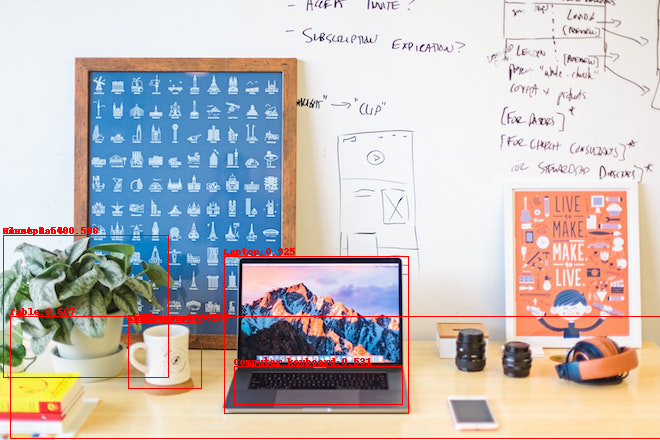

In [9]:
highlight_objects('objects.jpg', response['responses'][0]['localizedObjectAnnotations'])

### Response メッセージの中身を確認してみよう
Responseメッセージは、JSONの形式で返ってきます。どんなデータが内包されているのか、確認してみましょう。

In [10]:
response['responses'][0]['localizedObjectAnnotations']

[{'boundingPoly': {'normalizedVertices': [{'x': 0.34023532, 'y': 0.5828236},
    {'x': 0.61905885, 'y': 0.5828236},
    {'x': 0.61905885, 'y': 0.9397647},
    {'x': 0.34023532, 'y': 0.9397647}]},
  'mid': '/m/01c648',
  'name': 'Laptop',
  'score': 0.9247296},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/m/03_wxk',
  'name': 'Kitchenware',
  'score': 0.73515165},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/m/04brg2',
  'name': 'Tableware',
  'score': 0.63077563},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/

## ロゴ検知
ロゴ検知では、画像中にある（有名ブランドなどの）ロゴを検出します。

### Request メッセージを構築してみよう
ここでは、 **googleplex.jpg** の画像を使います。Requestのしかたは先ほどと同じで、画像データと `type`が異なるだけです。

In [0]:
from base64 import b64encode

with open('googleplex.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'LOGO_DETECTION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

### Cloud Vision API にリクエストを投げてみよう

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

### 検出結果を可視化しよう
ここでも、検出したロゴの矩形情報が得られるのでそれを描画してみましょう。

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_logos を定義

from PIL import Image, ImageDraw

def highlight_logos(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  for obj in objects:
    vertex_lt = tuple(obj['boundingPoly']['vertices'][0].values())
    vertex_rb = tuple(obj['boundingPoly']['vertices'][2].values())
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    obj['description']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=obj['description'] + ':' + str(format(obj['score'], '.3f')),
              fill='red')    
  display(image)

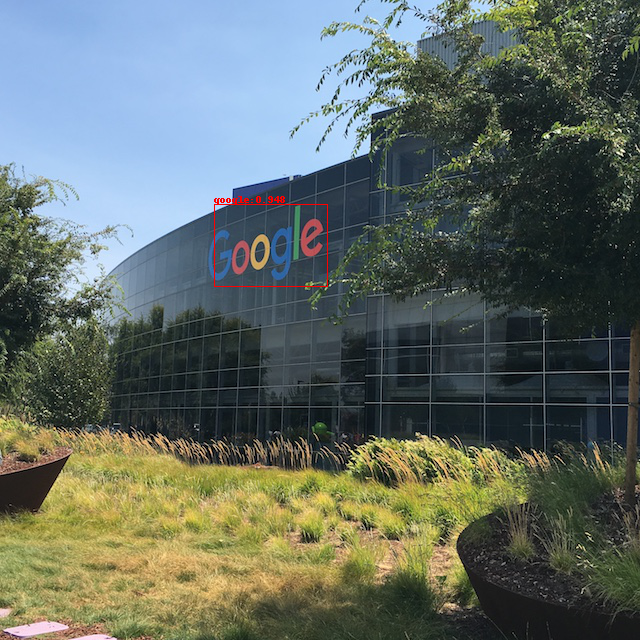

In [16]:
highlight_logos('googleplex.jpg', response['responses'][0]['logoAnnotations'])

### Response メッセージの中身を確認してみよう
オブジェクト検知とほぼ同じ形式です。`mid`とは、[Google Knowledge Graph](https://en.wikipedia.org/wiki/Knowledge_Graph)のIDです。

In [17]:
response['responses'][0]['logoAnnotations']

[{'boundingPoly': {'vertices': [{'x': 214, 'y': 204},
    {'x': 327, 'y': 204},
    {'x': 327, 'y': 286},
    {'x': 214, 'y': 286}]},
  'description': 'google',
  'mid': '/m/045c7b',
  'score': 0.9477}]

## ランドマーク検知
ランドマーク検知では、有名な観光地や場所を特定することができます。

### Request メッセージを構築してみよう

In [0]:
from base64 import b64encode

with open('osaka.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'LANDMARK_DETECTION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

### Cloud Vision API にリクエストを投げてみよう

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

### 検出結果を可視化しよう

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_landmarks を定義

from PIL import Image, ImageDraw

def highlight_landmarks(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  for obj in objects:
    vertex_lt = tuple(obj['boundingPoly']['vertices'][0].values())
    vertex_rb = tuple(obj['boundingPoly']['vertices'][2].values())
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    obj['description']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=obj['description'] + ':' + str(format(obj['score'], '.3f')),
              fill='red')    
  display(image)

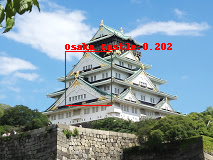

In [23]:
highlight_landmarks('osaka.jpg', response['responses'][0]['landmarkAnnotations'])

**プラス One!**  
Maps APIを使って検知したランドマークの位置を地図に表示しよう。地図の表示は[Google Maps Static API](https://console.cloud.google.com/apis/library/static-maps-backend.googleapis.com) を使っているので、別途APIを有効にする必要があります。

In [27]:
from IPython.core.display import HTML
latlng = response['responses'][0]['landmarkAnnotations'][0]['locations'][0]['latLng']

html = """
<img src="https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom=14&size=480x300&key={}">
""".format(latlng['latitude'], latlng['longitude'], APIKEY)
display(HTML(html))

### Response メッセージの中身を確認してみよう

In [25]:
response['responses'][0]['landmarkAnnotations']

[{'boundingPoly': {'vertices': [{'x': 65, 'y': 51},
    {'x': 111, 'y': 51},
    {'x': 111, 'y': 105},
    {'x': 65, 'y': 105}]},
  'description': 'Osaka Castle',
  'locations': [{'latLng': {'latitude': 34.686777, 'longitude': 135.525799}}],
  'mid': '/m/024b_g',
  'score': 0.20166214}]

## Tips

### 複数の検知を一度にリクエストすることもできます。

In [0]:
# Requestのmy_features部分を以下のように複数指定する
my_features = [
    {'type':'OBJECT_LOCALIZATION', 'model':'builtin/stable'},
    {'type':'LOGO_DETECTION', 'model':'builtin/stable'},
    {'type':'LANDMARK_DETECTION', 'model':'builtin/stable'}
]